In [ ]:
# 패키지 및 데이터 로드
import os
import pandas as pd
import numpy as np

audio1 = pd.read_excel('/home/baek1453/CapstoneDesign/Original_Data/audio_features1.xlsx')
audio2 = pd.read_excel('/home/baek1453/CapstoneDesign/Original_Data/audio_features2.xlsx')
audio3 = pd.read_excel('/home/baek1453/CapstoneDesign/Original_Data/audio_features3.xlsx')
audio4 = pd.read_excel('/home/baek1453/CapstoneDesign/Original_Data/audio_features4.xlsx')
audio5 = pd.read_excel('/home/baek1453/CapstoneDesign/Original_Data/audio_features5.xlsx')
audio6 = pd.read_excel('/home/baek1453/CapstoneDesign/Original_Data/audio_features6.xlsx')
audio7 = pd.read_excel('/home/baek1453/CapstoneDesign/Original_Data/audio_features7.xlsx')

In [7]:
# 데이터 합치기
audio = pd.concat([audio1, audio2, audio3, audio4, audio5, audio6, audio7], axis = 0)

In [8]:
# 나이를 그룹화하여 새로운 컬럼 생성 (예: 20대, 30대)
audio['Age Group'] = pd.cut(audio['Age'], bins=[0, 19, 29, 39, 49, 59], labels=['10s', '20s', '30s', '40s', '50s'])

In [9]:
audio.head()

,File Name,Sample Rate (Hz),Duration (Seconds),Average Volume,Zero Crossing Rate,Spectral Centroid,Spectral Bandwidth,Spectral Roll-off,First MFCC,Age,Gender,Area,Age Group
0,일반남여_일반통합05_M_1455308554-6_37_수도권_실내_06313.wav,16000,2.303437,0.012909,0.166945,2079.575206,1871.350691,4148.003472,-432.089294,37,M,수도권,30s
1,일반남여_일반통합05_M_1462181814_29_수도권_실내_06317.wav,16000,3.993625,0.014553,0.071984,873.132010,893.718239,1669.375000,-470.837769,29,M,수도권,20s
2,일반남여_일반통합05_M_1462181814_29_수도권_실내_06319.wav,16000,5.108125,0.019076,0.052240,769.332142,842.287262,1439.697266,-433.277252,29,M,수도권,20s
3,일반남여_일반통합05_M_1462181814_29_수도권_실내_06323.wav,16000,4.458000,0.012939,0.055514,758.424047,860.584414,1298.437500,-494.684540,29,M,수도권,20s
4,일반남여_일반통합05_M_1462181814_29_수도권_실내_06325.wav,16000,4.086500,0.005904,0.035431,480.998378,491.214730,808.105469,-565.200867,29,M,수도권,20s


In [2]:
# 패키지 불러오기
import librosa
import os
import pandas as pd
import numpy as np
import scipy.io.wavfile as wavf
import random
from sklearn.model_selection import train_test_split
import parselmouth  # Extract f0, jitter, shimmer, NHR from .wav file
from parselmouth.praat import call
from scipy.stats import norm  # Calculate value of probability density function of normal distribution
from sklearn import linear_model  # Logistic Regression module
from sklearn.ensemble import RandomForestClassifier  # Random Forest module
from sklearn.svm import SVC  # SVM module
from math import ceil
import joblib  # Use to save models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings  # Remove warnings
warnings.filterwarnings(action='ignore')

In [3]:
# 가속
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU를 사용합니다.")
else:
    print("GPU를 사용할 수 없습니다. CPU를 사용합니다.")

2024-06-04 15:35:18.809464: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 15:35:18.861762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 15:35:19.664779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU를 사용합니다.


2024-06-04 15:35:20.009939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 15:35:20.031726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 15:35:20.031861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
sr = 22050  # Signal Rate
categories = ['10s', '20s', '30s', '40s', '50s']
wav_unprocessed = "/home/baek1453/CapstoneDesign/Original_Data/자유대화 음성(일반남녀)/Training/prac_audio/not_gender_upa/"  # num of files [18590, 16433, 17661, 18589, 7698, 8077]
wav_processed = "/home/baek1453/CapstoneDesign/Original_Data/자유대화 음성(일반남녀)/Training/prac_audio/pa/"
wav_pickle = "/home/baek1453/CapstoneDesign/Data/pickle/"

In [95]:
def remove_silence(wav_dir):
  """음원 내에 음압이 0인 부분을 제거"""

  # y: 음 세기, sr: 1초당 데이터 수
  y, _ = librosa.load(wav_dir, sr=sr)

  # cut: 소리를 지우는 기준 음압
  cut = max(y) / 300
  y = pd.DataFrame(y)
  y = y[abs(y[0]) > cut].to_numpy()
  return y.T[0]

In [96]:
"""디렉토리 내 모든 .wav 파일에 remove_silence()를 실행하고 MFCC 벡터로 변환하여 저장"""

run = input("Run? [Y/N] ")
if run in ['Y', 'y']:
  X_mfcc = pd.DataFrame([])
  y_label = pd.DataFrame([], columns=["y_label"])
  for category in sorted(os.listdir(wav_unprocessed)):
    if category in categories:
      print("[Now Processing]", category)

      save_dir = wav_processed + "processed_" + category + "/"
      if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

      # for folder in os.listdir(wav_unprocessed + category):
      folder_dir = wav_unprocessed + category + "/"

      for file in sorted(os.listdir(folder_dir)):
          if file.endswith(".wav"):
            wav = folder_dir + file  # 음원 위치
            # print(wav)
            save = save_dir + category + "_" + file[5:]  # 저장 위치
            try:
              # 전처리한 음원의 MFCC 평균을 저장
              y = remove_silence(wav)
              X_mfcc = pd.concat([X_mfcc, pd.DataFrame(pd.DataFrame(librosa.feature.mfcc(y=y, sr=sr)).mean(axis=1)[1:]).T], axis=0, ignore_index=True)  # [1:]: 진동이 거의 없는 [0] 데이터 삭제
              y_label = pd.concat([y_label, pd.DataFrame([category[-3:]], columns=["y_label"])], axis=0, ignore_index=True)
            except Exception as e:
                print(f"Failed to process {file}: {e}")        
  print("[Finished]")

[Now Processing] 10s
[Now Processing] 20s
[Now Processing] 30s
[Now Processing] 40s
[Now Processing] 50s
[Finished]


In [97]:
X_mfcc, y_label

(               1          2          3          4          5          6   \
 0      107.436279   9.938106  15.499860 -26.788921  -8.134877 -21.130106   
 1       89.636520   9.788758   7.846515 -24.802292  -2.470343 -21.338428   
 2       93.831017   2.842420   3.950566 -30.286568  -2.780217 -23.258440   
 3       75.551170   9.399722  12.611285 -33.498066  -4.194895 -28.661516   
 4       96.140656   7.573533  11.852724 -31.740849  -4.039490 -19.640636   
 ...           ...        ...        ...        ...        ...        ...   
 21576   91.629501 -55.602810   0.878123 -14.601499  -3.545689 -30.655785   
 21577  106.095810 -47.596825   9.466966 -15.732354 -11.626897 -26.985321   
 21578  101.169113 -49.623356   0.129389 -27.244696 -12.399937 -21.826307   
 21579   88.513039 -41.609402 -15.213070 -46.478584  -5.733611 -23.986433   
 21580   80.945999 -59.402519 -11.391835 -35.165966  -6.569138 -30.084503   
 
               7          8          9          10         11         12  

In [98]:
"""음원의 MFCC 평균을 저장"""

X_mfcc.to_pickle(wav_pickle + "original22050_X_mfcc.pkl")
y_label.to_pickle(wav_pickle + "original22050_y_label.pkl")

# Load Data

In [5]:
X_mfcc = pd.read_pickle(wav_pickle + "original22050_X_mfcc.pkl")
y_label = pd.read_pickle(wav_pickle + "original22050_y_label.pkl")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_mfcc, y_label, test_size=0.2, random_state=1)

# Models

## Random Forest

In [101]:
"""2. Random Forest"""

forest = RandomForestClassifier(n_estimators=50, max_depth=20)
forest.fit(X_train, y_train)

# Save models
if not os.path.isfile(wav_pickle + "original_model_RandomForest.pkl"):
  joblib.dump(forest, wav_pickle + "original_model_RandomForest.pkl")

# Save prediction results
y_pred = pd.DataFrame(forest.predict(X_test), columns=["y_label"])
if not os.path.isfile(wav_pickle + "original_y_pred_RF.pkl"):
  y_pred.to_pickle(wav_pickle + "original_y_pred_RF.pkl")

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report

# 데이터 로드 부분은 생략 (X_train, X_test, y_train, y_test가 준비되어 있다고 가정)
# ...

# 랜덤 포레스트 모델 생성 및 학습
forest = RandomForestClassifier(
    n_estimators=200,       # 트리의 수
    max_depth=20,            # 트리의 최대 깊이
    min_samples_split=2,     # 내부 노드를 분할하는 최소 샘플 수
    min_samples_leaf=1,      # 리프 노드의 최소 샘플 수
    max_features=3,     # 각 분할에서 고려할 피처의 수 (auto는 전체 피처 수)
    bootstrap=True,          # 부트스트랩 샘플링 사용
    oob_score=False          # OOB 점수 계산
)
forest.fit(X_train, y_train)

# 중요도 기반 피쳐 선택
selector = SelectFromModel(forest, threshold='0.5*median', prefit=True)
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# 피쳐가 축소된 데이터로 모델 재학습
forest.fit(X_train_reduced, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred = forest.predict(X_test_reduced)

# 모델 성능 검증
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[  70   55   49   24    1]
 [   2 1583   47   32    7]
 [   4   82  750   86    8]
 [   1   74   95  768    2]
 [   0   73   24   24  456]] 

Classification Report:
              precision    recall  f1-score   support

         10s     0.9091    0.3518    0.5072       199
         20s     0.8479    0.9473    0.8949      1671
         30s     0.7772    0.8065    0.7916       930
         40s     0.8223    0.8170    0.8196       940
         50s     0.9620    0.7903    0.8677       577

    accuracy                         0.8402      4317
   macro avg     0.8637    0.7426    0.7762      4317
weighted avg     0.8452    0.8402    0.8347      4317



## XGBoost

In [91]:
import numpy as np
import pandas as pd
import optuna
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# 데이터 스케일링 및 XGBoost 모델 생성
scaler = StandardScaler()

# 클래스 레이블을 숫자로 변환
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 최적의 하이퍼파라미터 설정
best_params = {
    'n_estimators': 256,
    'max_depth': 7,
    'learning_rate': 0.0048,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False
}

# XGBClassifier 모델 생성
best_model = XGBClassifier(**best_params)

# 파이프라인 구성
pipeline = Pipeline([
    ('scaler', scaler),
    ('xgb', best_model)
])

# 모델 학습
pipeline.fit(X_train, y_train_encoded)

# 중요도 기반 피쳐 선택을 위한 SelectFromModel 객체 생성 및 학습(fit)
selector = SelectFromModel(best_model, threshold='0.5*median', prefit=True)

# 피쳐 선택 진행
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# 최적의 모델로 피쳐가 축소된 데이터로 모델 재학습
best_model.fit(X_train_reduced, y_train_encoded)

# 테스트 데이터에 대한 예측 수행
y_pred_encoded = best_model.predict(X_test_reduced)
y_pred = le.inverse_transform(y_pred_encoded)

# 모델 성능 검증
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# 예측 결과 저장
# y_pred_df = pd.DataFrame(y_pred)
# y_pred_df.to_pickle("age_y_pred_XGB.pkl")

Confusion Matrix:
[[ 60  20  16  10   0]
 [  1 798  19  14   4]
 [  1  28 403  31   4]
 [  4  15  44 394   4]
 [  0   9   8  11 261]] 

Classification Report:
              precision    recall  f1-score   support

         10s     0.9091    0.5660    0.6977       106
         20s     0.9172    0.9545    0.9355       836
         30s     0.8224    0.8630    0.8422       467
         40s     0.8565    0.8547    0.8556       461
         50s     0.9560    0.9031    0.9288       289

    accuracy                         0.8874      2159
   macro avg     0.8923    0.8283    0.8520      2159
weighted avg     0.8886    0.8874    0.8857      2159



## Multi Layer Perceptron

Confusion Matrix:
[[ 155    9   25   10    0]
 [  10 1593   36   20   12]
 [  16   42  800   59   13]
 [  15   28   64  820   13]
 [   2   14   17   14  530]] 

Classification Report:
              precision    recall  f1-score   support

         10s     0.7828    0.7789    0.7809       199
         20s     0.9448    0.9533    0.9491      1671
         30s     0.8493    0.8602    0.8547       930
         40s     0.8884    0.8723    0.8803       940
         50s     0.9331    0.9185    0.9258       577

    accuracy                         0.9029      4317
   macro avg     0.8797    0.8767    0.8781      4317
weighted avg     0.9029    0.9029    0.9029      4317



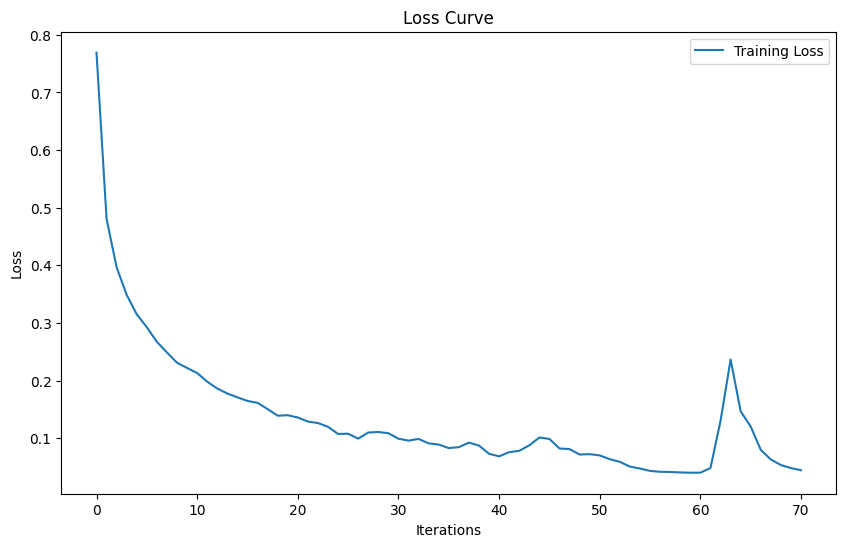

In [9]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# 데이터 스케일링 및 MLP 모델 생성
scaler = StandardScaler()
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 100),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate_init=0.0048,
    max_iter=300,
    random_state=42
)

# 클래스 레이블을 숫자로 변환
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 파이프라인 구성
pipeline = Pipeline([
    ('scaler', scaler),
    ('mlp', mlp)
])

# 모델 학습
pipeline.fit(X_train, y_train_encoded)

# 학습 과정에서 loss 값 저장
loss_values = pipeline.named_steps['mlp'].loss_curve_

# 테스트 데이터에 대한 예측 수행
y_pred_encoded = pipeline.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

# 모델 성능 검증
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# loss 값 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 예측 결과 저장
# y_pred_df = pd.DataFrame(y_pred)
# y_pred_df.to_pickle("age_y_pred_MLP.pkl")
